![Forecasting Demo 2: PyTorch Forecasting](https://raw.githubusercontent.com/VectorInstitute/forecasting-bootcamp/media-assets-do-not-merge/forecasting-demo-2.png?token=GHSAT0AAAAAABQMCWQFIGE34XPH3MQR2BBEYRHXQCQ)

[PyTorch Forecasting](https://github.com/jdb78/pytorch-forecasting) is a package/repository that provides convenient implementations of several leading deep learning-based forecasting models, namely [Temporal Fusion Transformers](https://arxiv.org/pdf/1912.09363.pdf), [N-BEATS](http://arxiv.org/abs/1905.10437), and [DeepAR](https://www.sciencedirect.com/science/article/pii/S0169207019301888). PyTorch Forecasting is built using [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/), making it easier to train in multi-GPU compute environments, out-of-the-box. 

**Note for Colab users:** Run the following cell to install PyTorch Forecasting. After installation completes, you will likely need to restart the Colab runtime. If this is the case, a button `RESTART RUNTIME` will appear at the bottom of the next cell's output.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch-forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline, DeepAR, GroupNormalizer, MultiNormalizer, EncoderNormalizer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import MAPE, MAE, MASE
from pytorch_forecasting.metrics import NormalDistributionLoss

In [3]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

## Data Loading

We will continue with the same example dataset and task as the previous demo.

In [2]:
# data_filename = "/content/drive/MyDrive/bootcamp_datasets/boc_exchange/dataset.csv"
data_filename = '/h/esinuk/forecasting-bootcamp/evan_forecasting_notebooks/m5_agg.csv'
data_df = pd.read_csv(data_filename, index_col=0)
data_df.index = pd.to_datetime(data_df.index)
data_df = data_df.reset_index().rename({'index':'date'}, axis=1)
data_df

,date,all,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,...,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
0,2011-01-29,32631,14195,9438,8998,4337,3494,4739,1625,2556,...,23178,3764,5689,2343,4094,16741,3610,154,4105,1584
1,2011-01-30,31749,13805,9630,8314,4155,3046,4827,1777,2687,...,22758,3357,5634,2216,4209,16333,3172,185,3858,1776
2,2011-01-31,23783,10108,6778,6897,2816,2121,3785,1386,1822,...,17174,2682,3927,1657,3174,12343,2497,185,2827,1100
3,2011-02-01,25412,11047,7381,6984,3051,2324,4232,1440,2258,...,18878,2669,3865,1508,3606,13764,2531,138,2732,1133
4,2011-02-02,19146,9925,5912,3309,2630,1942,3817,1536,1694,...,14603,1814,2729,1209,2869,10525,1714,100,1802,927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,2016-05-18,37096,15678,10375,11043,3995,3789,5375,2519,3147,...,24790,3740,8566,3073,4648,17069,3291,449,6641,1925
1937,2016-05-19,36963,16297,9162,11504,4136,4037,5580,2544,2748,...,24737,3475,8751,3251,4551,16935,3027,448,6759,1992
1938,2016-05-20,42552,17430,12303,12819,4433,4751,5542,2704,3664,...,28136,4143,10273,3735,4815,19586,3761,382,7974,2299
1939,2016-05-21,51518,23103,13681,14734,5764,7120,7073,3146,4167,...,33599,5333,12586,4195,5940,23464,4832,501,9668,2918


In [90]:
for col in data_df.columns[1:]:
    data_df.loc[:, col] = data_df.loc[:, col].astype(float)

## Data Splitting

We immediately split the data into training and test sets. We can later split the training set into training and validation.

In [91]:
train_size = 0.8

train_df = data_df.iloc[:int(len(data_df)*train_size)]
test_df = data_df.iloc[int(len(data_df)*train_size):]

## Data Formatting

PyTorch Forecasting expects data to be formatted using its own [TimeSeriesDataSet](https://pytorch-forecasting.readthedocs.io/en/latest/data.html) objects. Building a TimeSeriesDataSet begins with a Pandas DataFrame, and like with Prophet and NeuralProphet, we need to add certain custom columns.

For this demo, we are once again specifying a lead time of 30 days and we will withhold the last 20% of data for testing. In the code below, we are very careful to ensure that when training and validating the model, it does not have access to the withheld data.

## Time Series Data Formatting

PyTorch Forecasting models can accomodate datasets consisting of multiple, coincident time series in several ways. As per the [documentation](https://pytorch-forecasting.readthedocs.io/en/latest/data.html), a combination of `group_id` and `time_idx` identify a sample in the data, and that *if we have only one time series, to set* `group_id` *to a constant.*

`time_idx` is an *integer column denoting the time index*. This, as opposed to the `date` column, is used to determine the temporal sequence of samples. 

In [92]:
lag_time = 30
lead_time = 30

train_df = train_df.reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().rename({'index':'time_idx'}, axis=1)

train_df['group_ids'] = 0
test_df['group_ids'] = 0

In [93]:
train_df

,time_idx,date,all,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,...,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,group_ids
0,0,2011-01-29,32631.0,14195.0,9438.0,8998.0,4337.0,3494.0,4739.0,1625.0,...,3764.0,5689.0,2343.0,4094.0,16741.0,3610.0,154.0,4105.0,1584.0,0
1,1,2011-01-30,31749.0,13805.0,9630.0,8314.0,4155.0,3046.0,4827.0,1777.0,...,3357.0,5634.0,2216.0,4209.0,16333.0,3172.0,185.0,3858.0,1776.0,0
2,2,2011-01-31,23783.0,10108.0,6778.0,6897.0,2816.0,2121.0,3785.0,1386.0,...,2682.0,3927.0,1657.0,3174.0,12343.0,2497.0,185.0,2827.0,1100.0,0
3,3,2011-02-01,25412.0,11047.0,7381.0,6984.0,3051.0,2324.0,4232.0,1440.0,...,2669.0,3865.0,1508.0,3606.0,13764.0,2531.0,138.0,2732.0,1133.0,0
4,4,2011-02-02,19146.0,9925.0,5912.0,3309.0,2630.0,1942.0,3817.0,1536.0,...,1814.0,2729.0,1209.0,2869.0,10525.0,1714.0,100.0,1802.0,927.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,1547,2015-04-25,43598.0,19071.0,12049.0,12478.0,6019.0,3230.0,7251.0,2571.0,...,4519.0,11531.0,3272.0,4967.0,19309.0,3991.0,528.0,9152.0,2379.0,0
1548,1548,2015-04-26,43406.0,19426.0,12387.0,11593.0,5815.0,2947.0,7890.0,2774.0,...,4463.0,10800.0,3220.0,4987.0,19936.0,3980.0,483.0,8480.0,2320.0,0
1549,1549,2015-04-27,33444.0,14773.0,9873.0,8798.0,3995.0,2257.0,5909.0,2612.0,...,3412.0,7923.0,2683.0,4303.0,15123.0,3045.0,367.0,6253.0,1670.0,0
1550,1550,2015-04-28,29750.0,13044.0,8805.0,7901.0,3526.0,1930.0,5420.0,2168.0,...,3098.0,7276.0,2474.0,3608.0,13294.0,2792.0,306.0,5678.0,1598.0,0


## Preparing a TimeSeriesDataSet for N-BEATS

N-BEATS is a univariate forecasting method. As such, it can only process one variable at a time.

In [95]:
train_df_nbeats = train_df.melt(id_vars=['time_idx', 'date'], value_vars=data_df.columns, var_name='group_ids')
train_df_nbeats.head()

,time_idx,date,group_ids,value
0,0,2011-01-29,all,32631.0
1,1,2011-01-30,all,31749.0
2,2,2011-01-31,all,23783.0
3,3,2011-02-01,all,25412.0
4,4,2011-02-02,all,19146.0


In [98]:
train_df_nbeats.groupby(['time_idx', 'date']).size().sort_values(ascending=False)

time_idx  date      
0         2011-01-29    24
1019      2013-11-13    24
1041      2013-12-05    24
1040      2013-12-04    24
1039      2013-12-03    24
                        ..
514       2012-06-26    24
513       2012-06-25    24
512       2012-06-24    24
511       2012-06-23    24
1551      2015-04-29    24
Length: 1552, dtype: int64

The following code defines the training/validation split and important parts of the prediction task - the lag time and lead time. Here we are specifying that 25% of the training data should be used for validation. In total, this results in a 60/20/20 train/valid/test split (since 25% of 80% is 20% of the initial 100%).

In [99]:
# define dataset
valid_size = 0.25  
max_encoder_length = lag_time
max_prediction_length = lead_time
training_cutoff = train_df_nbeats["time_idx"][:int((1 - valid_size)*train_df_nbeats["time_idx"].max())].values[-1]
context_length = max_encoder_length
prediction_length = max_prediction_length

Since NBEATS is actually a univariate forecasting model, it makes sense that pytorch-forecasting does not support specifying explanatory variables as `time_varying_unknown_reals`. Earlier, we used the Pandas function `melt` to reshape the data into a single `value` column that is uniquely indexed by pairs of `(time_idx, group_ids)`.

In [100]:
training = TimeSeriesDataSet(
    train_df_nbeats.loc[train_df_nbeats.time_idx <= training_cutoff],  # Applying the training cutoff
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df_nbeats.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["value"], 
)

In [101]:
training.categoricals

[]

In [102]:
validation = TimeSeriesDataSet.from_dataset(training, train_df_nbeats, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=1)

## Training the model

In our first effort to train the N-BEATS model, we adopt the default configuration suggested by the pytorch-forecasting [tutorials](https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/ar.html).

In [112]:
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=15,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=1.0,
)

net = NBeats.from_dataset(
    training,
    learning_rate=1e-4,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    # widths=[16, 16],
    # backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.717     Total estimated model params size (MB)
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_l

Validation sanity check: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.844


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.114 >= min_delta = 0.0001. New best score: 0.730


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 0.714


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.706


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.702


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.699


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.695


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.694


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.693


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.691


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.691


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.690


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.688


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.686


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.685


## Testing the model

We can now evaluate the model using the test set. Even though we trained the N-BEATS model on all variables in the training set, we will only evaluate performance on `USD_CLOSE` as a direct comparison to earlier experiments with Prophet and NeuralProphet. The following code creates a dataloader for the test set.

In [113]:
test_dataset = TimeSeriesDataSet(
    test_df,
    time_idx="time_idx",
    target="all",
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["all"],
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

## Collect test set predictions

In [114]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_model.predict(test_dataloader)

## Plot model forecasts at max lead time

Like in Demo 1, we are plotting the predictions at max lead time as well as one individual example forecast. Feel free to modify the `start` variable to plot different examples.

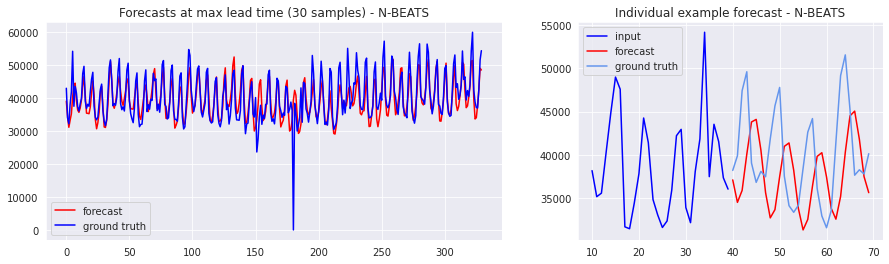

In [115]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(actuals_np.shape[0]):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4), gridspec_kw={'width_ratios': [3, 2]})
ax1.plot(indexes, preds, color='red', label='forecast')
ax1.plot(indexes, trues, color='blue', label='ground truth')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax1.legend()

start = 10
ax2.plot(list(range(start,start+30)), actuals_np[start], color='blue', label='input')
ax2.plot(list(range(start+30, start+60)), predictions_np[start], color='red', label='forecast')
ax2.plot(list(range(start+30, start+60)), actuals_np[start+30], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - N-BEATS")
ax2.legend(loc='upper left')

plt.show()

## Compare results to previous experiment

If you have run through experiments using **Demo 1**, you can load the results file here and continue the experiment.

In [18]:
results_df = pd.read_csv("./exchange_rate_mean_test_metrics.csv", index_col=0)
results_df.sort_values('mae')

,mse,rmse,mae,mape
persistence_mean_metrics,0.000544,0.020601,0.017738,0.013376
neural_prophet_last_sample_only_mean_metrics,0.000619,0.022734,0.019712,0.014834
mean_window_mean_metrics,0.000912,0.026212,0.023677,0.017827
neural_prophet_sparse_ar_mean_metrics,0.007931,0.064557,0.050069,0.037748
prophet_mean_metrics,0.004840,0.061076,0.059036,0.044389
neural_prophet_baseline_mean_metrics,0.015059,0.106165,0.102589,0.077813


To ensure consistency, we will redefine the same metrics from **Demo 1**.

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

metrics = {
    'mse': mean_squared_error,
    'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error
}

def compute_error_statistics(error_metrics_dict, exp_name):
    return {
        'mean': pd.DataFrame(error_metrics_dict).mean(axis=0).rename(f'{exp_name}_mean_metrics'),
        'std': pd.DataFrame(error_metrics_dict).std(axis=0).rename(f'{exp_name}_std_metrics'),
        'max': pd.DataFrame(error_metrics_dict).max(axis=0).rename(f'{exp_name}_max_metrics'),
    }

def compute_baseline_error_metrics(predictions, actuals):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(predictions)):
    
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=actuals[i], y_pred=predictions[i]))

    return errors

In [20]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

nbeats_errors = compute_baseline_error_metrics(predictions_np, actuals_np)
nbeats_stats = compute_error_statistics(nbeats_errors, 'nbeats')
nbeats_stats['mean']

mse     0.000571
rmse    0.021109
mae     0.018175
mape    0.013690
Name: nbeats_mean_metrics, dtype: float32

In [21]:
results_df = results_df.append(nbeats_stats['mean'])
results_df.sort_values('mae')

,mse,rmse,mae,mape
persistence_mean_metrics,0.000544,0.020601,0.017738,0.013376
nbeats_mean_metrics,0.000571,0.021109,0.018175,0.013690
neural_prophet_last_sample_only_mean_metrics,0.000619,0.022734,0.019712,0.014834
mean_window_mean_metrics,0.000912,0.026212,0.023677,0.017827
neural_prophet_sparse_ar_mean_metrics,0.007931,0.064557,0.050069,0.037748
prophet_mean_metrics,0.004840,0.061076,0.059036,0.044389
neural_prophet_baseline_mean_metrics,0.015059,0.106165,0.102589,0.077813


## DeepAR

We will now add pytorch-forecasting's implementation of DeepAR to our experiment. The implementation is based on the original [paper](https://www.sciencedirect.com/science/article/pii/S0169207019301888). DeepAR is a method for probabilistic forecasting with autoregressive recurrent neural networks. DeepAR learns a *global model* from all historical data in the dataset, similar to N-BEATS. 

In [22]:
deepar_training = TimeSeriesDataSet(
    train_df_nbeats.loc[train_df_nbeats.time_idx <= training_cutoff],  # Applying the training cutoff
    time_idx="time_idx",
    target="value",
    group_ids=['group_ids'],
    min_encoder_length=context_length,
    max_encoder_length=context_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df_nbeats.group_ids)},
    time_varying_unknown_reals=["value"],
    time_varying_known_reals=["time_idx"],
    target_normalizer=GroupNormalizer(groups=["group_ids"]),
    add_relative_time_idx=False,
    add_target_scales=True,
    randomize_length=None,
)

In [23]:
deepar_validation = TimeSeriesDataSet.from_dataset(deepar_training, 
                                                   train_df_nbeats, 
                                                   min_prediction_idx=training_cutoff + 1)
batch_size = 64
train_dataloader = deepar_training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = deepar_validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [24]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=1)
net = DeepAR.from_dataset(deepar_training)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [25]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=8,
    gpus=1,
    gradient_clip_val=0.1,
    # weights_summary="top",
    # callbacks=[early_stop_callback],
    limit_train_batches=1.0,
)

net = DeepAR.from_dataset(
    deepar_training,
    hidden_size=32,
    dropout=0.1,
    loss=NormalDistributionLoss(),
    learning_rate=1e-4,
    log_interval=10,
    log_val_interval=1,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 13.3 K
4 | distribution_projector | Linear                 | 66    
------------------------------------------------------------------
13.

Validation sanity check: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Global seed set to 42
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [26]:
# save datasets
deepar_training.save("training.pkl")
deepar_validation.save("validation.pkl")

In [27]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)
print(best_model_path)

/ssd003/home/kkoch/forecasting-bootcamp/demos/lightning_logs/version_6317163/checkpoints/epoch=7-step=3279.ckpt


### Load the model from a saved checkpoint (optional)

In [28]:
best_model = DeepAR.load_from_checkpoint(best_model_path)

### Prepare the test dataset with necessary preprocessing options

Since we only want to evaluate on **USD_CLOSE**, the test dataset should only contain data from this series (as opposed to all of them vertically stacked like we did for training).

In [29]:
deep_ar_test_dataset = TimeSeriesDataSet(
    test_df,
    time_idx="time_idx",
    target="USD_CLOSE",
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(test_df.group_ids)},
    time_varying_unknown_reals=["USD_CLOSE"],
    time_varying_known_reals=["time_idx"],
    target_normalizer=GroupNormalizer(groups=["group_ids"]),
    add_relative_time_idx=False,
    add_target_scales=True,
    randomize_length=None,
)

deepar_test_dataloader = deep_ar_test_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

### Same visualization and evaluation code that we used previously

In [30]:
actuals = torch.cat([y[0] for x, y in iter(deepar_test_dataloader) if y[0].shape[1] == 30])
print(actuals.shape)

torch.Size([672, 30])


In [31]:
predictions = best_model.predict(deepar_test_dataloader)
print(predictions.shape)

torch.Size([672, 30])


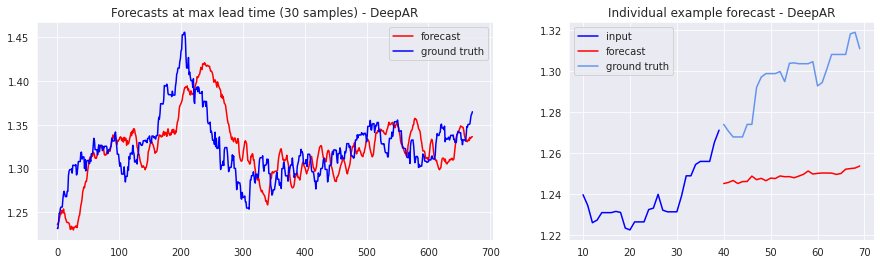

In [32]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(actuals_np.shape[0]):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4), gridspec_kw={'width_ratios': [3, 2]})
ax1.plot(indexes, preds, color='red', label='forecast')
ax1.plot(indexes, trues, color='blue', label='ground truth')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - DeepAR")
ax1.legend()

start = 10
ax2.plot(list(range(start,start+30)), actuals_np[start], color='blue', label='input')
ax2.plot(list(range(start+30, start+60)), predictions_np[start], color='red', label='forecast')
ax2.plot(list(range(start+30, start+60)), actuals_np[start+30], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - DeepAR")
ax2.legend(loc='upper left')

plt.show()

In [33]:
deepar_errors = compute_baseline_error_metrics(predictions_np, actuals_np)
deepar_stats = compute_error_statistics(deepar_errors, 'deepAR')
deepar_stats['mean']

mse     0.000557
rmse    0.020712
mae     0.017962
mape    0.013557
Name: deepAR_mean_metrics, dtype: float32

In [34]:
results_df = results_df.append(deepar_stats['mean'])
results_df.sort_values('mae')

,mse,rmse,mae,mape
persistence_mean_metrics,0.000544,0.020601,0.017738,0.013376
deepAR_mean_metrics,0.000557,0.020712,0.017962,0.013557
nbeats_mean_metrics,0.000571,0.021109,0.018175,0.013690
neural_prophet_last_sample_only_mean_metrics,0.000619,0.022734,0.019712,0.014834
mean_window_mean_metrics,0.000912,0.026212,0.023677,0.017827
neural_prophet_sparse_ar_mean_metrics,0.007931,0.064557,0.050069,0.037748
prophet_mean_metrics,0.004840,0.061076,0.059036,0.044389
neural_prophet_baseline_mean_metrics,0.015059,0.106165,0.102589,0.077813


In [1]:
import pickle